# Phần 1: Import thư viện

## Thêm thư viện pandas, numpy, matplotlib, TfidVectorizer từ sklearn

In [5]:
# Load packages
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer 
import matplotlib.pyplot as plt

In [19]:
df_cryptonews = pd.read_csv('cryptonews.csv')

cond_subject = (
    df_cryptonews['subject'].isin(['blockchain', 'bitcoin'])
)
cond_text = df_cryptonews['text'].str.contains('bitcoin', case=False, na=False)

cond_title = df_cryptonews['title'].str.contains('bitcoin', case=False, na=False)

df_filtered = df_cryptonews[cond_subject & (cond_text | cond_title)]

df_filtered = df_filtered.drop_duplicates()



In [20]:
import json
import pandas as pd

with open("001_data.sql", "w", encoding="utf-8") as f:
    for _, row in df_filtered.iterrows():
        date_str = pd.to_datetime(row['date']).strftime('%Y-%m-%d %H:%M:%S')

        # Ensure sentiment is valid JSON
        sentiment_val = row['sentiment']
        if isinstance(sentiment_val, str):
            try:
                # Try to parse as JSON first
                sentiment_obj = json.loads(sentiment_val)
            except json.JSONDecodeError:
                try:
                    # Try to parse as Python literal (e.g., "{'class': 'negative', ...}")
                    import ast
                    sentiment_obj = ast.literal_eval(sentiment_val)
                except Exception:
                    # Fallback: wrap raw string
                    sentiment_obj = {"raw": sentiment_val}
        else:
            sentiment_obj = sentiment_val

        sentiment_json = json.dumps(sentiment_obj, ensure_ascii=False)

        source_str = str(row['source']).replace("'", "''")
        subject_str = str(row['subject']).replace("'", "''")
        text_str = str(row['text']).replace("'", "''")
        title_str = str(row['title']).replace("'", "''")
        url_str = str(row['url']).replace("'", "''")

        f.write(
            f"INSERT INTO crypto_news (date, sentiment, source, subject, text, title, url) "
            f"VALUES ('{date_str}', '{sentiment_json}'::jsonb, '{source_str}', '{subject_str}', "
            f"'{text_str}', '{title_str}', '{url_str}') "
            f"ON CONFLICT DO NOTHING;\n"
        )

Hiển thị các tin tức Crypto lên

### Tạo vector, vector hóa tài liệu

In [7]:
# create vectorizer 
vectorizer = TfidfVectorizer(stop_words='english') 
  
# vectorizer the text documents 
X_tfidf = vectorizer.fit_transform(df_cryptonews['title'])


Đoạn mã trên sử dụng TfidfVectorizer từ thư viện scikit-learn để chuyển đổi các tiêu đề tin tức từ dạng văn bản thành ma trận TF-IDF.
vectorizer = TfidfVectorizer(stop_words='english'): Đây là cách tạo một đối tượng TfidfVectorizer. Tham số stop_words='english' chỉ định rằng các từ dừng trong tiếng Anh (như "and", "the", "is", v.v.) sẽ được loại bỏ khỏi văn bản trước khi chuyển đổi thành vector TF-IDF.
X_tfidf = vectorizer.fit_transform(df_cryptonews['title']): Dòng này sử dụng phương thức fit_transform để chuyển đổi các tiêu đề tin tức từ DataFrame df_cryptonews thành ma trận TF-IDF. Đối tượng vectorizer đã được sử dụng trước đó để fit (tìm hiểu) từ vựng từ các tiêu đề tin tức và sau đó chuyển đổi chúng thành ma trận TF-IDF.
Kết quả X_tfidf là một ma trận mà mỗi hàng tương ứng với một tiêu đề tin tức, và mỗi cột tương ứng với một từ trong từ vựng đã được xây dựng từ các tiêu đề. Giá trị tại mỗi vị trí trong ma trận là giá trị TF-IDF của từ đó trong tiêu đề tương ứng.

## Hiển thị kích thước Samples và Features

In [8]:
print(f"n_samples: {X_tfidf.shape[0]}, n_features: {X_tfidf.shape[1]}")

n_samples: 31037, n_features: 17573


# Phần 2: Xử lí dữ liệu

## PCA

In [9]:
from sklearn.decomposition import PCA

# reduce the dimensionality of the data using PCA 
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(X_tfidf.toarray())

Đầu tiên import PCA từ thư viện sklearn.decompostion;
PCA(n_components=2): giới hạn chiều dữ liệu xuống còn 2;
X_tfidf.toarray(): biến X-tfidf thành mảng. Sau đó dùng fit_transform để giảm chiều dữ liệu bằng PCA;
=> reduced_data: mảng dữ liệu được giảm chiều bằng PCA

C:\Users\PC\AppData\Local\Temp\ipykernel_16724\4276048510.py:3: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


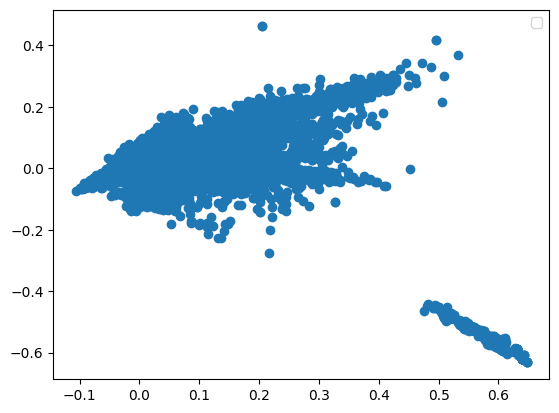

In [10]:
# plot the results of PCA
plt.scatter(reduced_data[:,0],reduced_data[:,1])
plt.legend() 
plt.show()

Dùng scatter để vẽ biểu đồ truyền 2 tham số reduced_data[:,0] và reduced_data[:,1]: 2 cột của mảng reduce_data;
dùng legend để thêm chú thích
dùng show để hiện thị biểu đồ đã vẽ

# Phần 3: Phân cụm dữ liệu

### K-means Clustering

In [11]:
from sklearn.cluster import KMeans 

# cluster the documents using k-means 
num_clusters = 2
kmeans = KMeans(n_clusters=num_clusters, n_init=5, 
                max_iter=500, random_state=23) 
kmeans.fit(X_tfidf) 

results = pd.DataFrame() 
results['document'] = df_cryptonews['title'] 
results['cluster'] = kmeans.labels_

Thêm KMeans từ thư viện sklearn.cluster; gán số lượng cụm muốn tạo clusters = 2; 
Cho KMeans các tham số lần lượt là số lương cụm muốn tạo = 2; số lần khởi tạo khác nhau = 5; số lần lặp lại tối đa cho mỗi lần khởi tạo là 500; seed cho việc khởi tạo ngẫu nhiên để có được kết quả tái tạo
kmeans.fit(X_tfidf): huấn luyện mô hình Kmeans trên dữ liệu đã được vector hóa bằng TF-IDF
pd.DataFrame(): lưu kết quả phân cụm trong DataFrame
results['document'] = df_cryptonews['title']: gán cột title của df_cryptonews vào cột document của DataFrame results để lưu trữ Title của các văn bản
results['cluster'] = kmeans.labels_: dán nhãn của mô hình kmeans vào cột cluster của DataFrame results

In [12]:
df_cryptonews['kmeans_labels'] = kmeans.labels_
df_cryptonews.to_csv("cryptonews_kmeans_labels_1.csv")

df_cryptonews['kmeans_labels'] = kmeans.labels_ : tạo cột mới có tên kmeans_labels trên FrameData của df_cryptonews sau đó gán nhãn cụm clusters labels(KMeans đã dự đoán) vào cột vừa mới tạo
df_cryptonews.to_csv("cryptonews_kmeans_labels_1.csv"): lưu DataFrame của df_cryptonews vào tệp CSV có tên là cryptonews_kmeans_labels_1.csv

In [13]:
wcss = [] 
for i in range(1, 21): 
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 23, n_init = 5)
    kmeans.fit(X_tfidf) 
    wcss.append(kmeans.inertia_)

Tạo một danh sách rỗng wcss; Tạo vòng lặp for chạy từ 1 đến 20 gán số lượng cụm cho chạy từ 1 đến 20; init = kmeans++ chỉ định dùng phương pháp Kmeans để chọn điểm khởi đầu giúp nhanh hơn. 
kmeans.fit(X_tfidf): huấn luyện mô hình kmeans trên dữ liệu đã vecto hóa
wcss.append(kmeans.inertia_): trả về giá trị của WCSS là tổng của bình phương khoảng cách từ các điểm dữ liệu tới trung tâm của cụm gần nhất của chúng. Giá trị này được thêm vào danh sách wcss để lưu trữ

In [14]:
df_kmeans = pd.DataFrame()
df_kmeans['clusters'] = [i for i in range(1,21)]
df_kmeans['inertia'] = wcss
df_kmeans

,clusters,inertia
0,1,30821.210855
1,2,30634.469311
2,3,30533.468157
3,4,30475.272145
4,5,30380.349581
5,6,30333.449720
6,7,30251.133669
7,8,30115.023170
8,9,30084.360075
9,10,30071.143691


Đầu tiên khởi tạo DataFrame
df_kmeans['clusters'] = [i for i in range(1,21)]: Dòng này tạo một cột có tên là 'clusters' trong DataFrame df_kmeans và gán giá trị cho cột này từ 1 đến 20. Điều này tạo ra một cột chứa các số lượng cụm tương ứng với số lượng lần lặp trong vòng lặp trước đó
df_kmeans['inertia'] = wcss: Dòng này tạo một cột mới có tên là 'inertia' trong DataFrame df_kmeans và gán giá trị từ danh sách wcss. wcss chứa giá trị của WCSS tương ứng với mỗi số lượng cụm từ 1 đến 20.

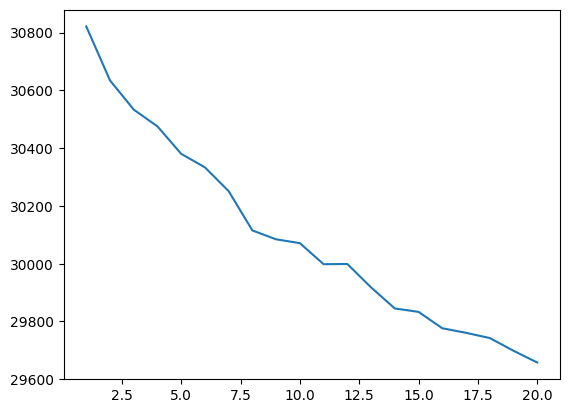

In [15]:
plt.figure()
plt.plot(df_kmeans['clusters'], df_kmeans['inertia'])
plt.show()

## Dùng k-means cho dữ liệu

figure: Dòng này tạo một hình vẽ mới
plt.plot(df_kmeans['clusters'], df_kmeans['inertia']): Dòng này vẽ biểu đồ đường bằng cách sử dụng giá trị của số lượng cụm (cột 'clusters' trong DataFrame df_kmeans) làm trục x và giá trị của WCSS (cột 'inertia' trong DataFrame df_kmeans) làm trục y.

In [16]:
# Let's try to set the clusters to 5
# cluster the documents using k-means 
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, n_init=5, 
                max_iter=500, random_state=23) 
kmeans.fit(X_tfidf) 

results = pd.DataFrame() 
results['document'] = df_cryptonews['title'] 
results['cluster'] = kmeans.labels_ 

df_cryptonews['kmeans_labels'] = kmeans.labels_
df_cryptonews.to_csv("cryptonews_kmeans_labels_2.csv")

Khởi tạo số lượng cụm = 5; 
kmeans = KMeans(n_clusters=num_clusters, n_init=5, max_iter=500, random_state=23): Bước khởi tạo của mô hình K-Means với số lượng cụm là 5. Tham số n_init chỉ định số lần khởi tạo khác nhau mà thuật toán sẽ thử, max_iter là số lần lặp tối đa cho mỗi lần khởi tạo, và random_state là seed cho việc khởi tạo ngẫu nhiên để kết quả có thể được tái tạo
kmeans.fit(X_tfidf): Dòng này huấn luyện mô hình K-Means trên dữ liệu đã được vector hóa bằng TF-IDF (X_tfidf).
results = pd.DataFrame(): Dòng này khởi tạo một DataFrame mới có tên là results để lưu trữ kết quả phân cụm.
results['document'] = df_cryptonews['title']: Dòng này gán cột 'title' từ DataFrame df_cryptonews vào cột 'document' của DataFrame results, để lưu trữ tiêu đề của các văn bản.
results['cluster'] = kmeans.labels_: Dòng này gán nhãn của các cụm mà mô hình K-Means đã phân loại vào cột 'cluster' của DataFrame results.
df_cryptonews['kmeans_labels'] = kmeans.labels_: Dòng này tạo một cột mới trong DataFrame df_cryptonews có tên là 'kmeans_labels' và gán nhãn của các cụm mà mô hình K-Means đã dự đoán cho mỗi văn bản vào cột này.
df_cryptonews.to_csv("cryptonews_kmeans_labels_2.csv"): Dòng này lưu DataFrame df_cryptonews vào một tệp CSV có tên là "cryptonews_kmeans_labels_2.csv" để lưu trữ kết quả phân cụm cho việc sử dụng hoặc phân tích sau này.

# Phần 4: Kết luận

## Tải dữ liệu về giá tiền điện tử

In [17]:
# Let's focus on bitcoin for now
df_bitcoin = pd.read_csv("/kaggle/input/cryptocurrency-historical-prices-coingecko/bitcoin.csv")
df_bitcoin['date'] = pd.to_datetime(df_bitcoin['date'])
df_bitcoin['date'] = df_bitcoin['date'].dt.date
df_bitcoin

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/cryptocurrency-historical-prices-coingecko/bitcoin.csv'

df_bitcoin = pd.read_csv("/kaggle/input/cryptocurrency-historical-prices-coingecko/bitcoin.csv"): Đọc dữ liệu từ tệp CSV có đường dẫn "/kaggle/input/cryptocurrency-historical-prices-coingecko/bitcoin.csv" vào DataFrame df_bitcoin. Đường dẫn này là một đường dẫn tới một tệp dữ liệu CSV chứa thông tin về giá lịch sử của Bitcoin.
df_bitcoin['date'] = pd.to_datetime(df_bitcoin['date']): Chuyển đổi cột 'date' trong DataFrame df_bitcoin thành định dạng dữ liệu datetime bằng cách sử dụng hàm pd.to_datetime(). Điều này chuyển đổi các giá trị trong cột 'date' từ chuỗi thành các đối tượng datetime, giúp xử lý và truy vấn ngày tháng một cách dễ dàng hơn.
df_bitcoin['date'] = df_bitcoin['date'].dt.date: Trích xuất ngày từ đối tượng datetime trong cột 'date' và gán lại vào cột 'date'. Điều này giữ lại chỉ ngày tháng (không bao gồm giờ và phút), giúp loại bỏ sự không cần thiết và tạo ra một cột 'date' mới chỉ chứa thông tin ngày tháng.
df_bitcoin: Cuối cùng, DataFrame df_bitcoin được hiển thị, chứa dữ liệu về giá lịch sử của Bitcoin với cột 'date' đã được chuyển đổi sang định dạng datetime và trích xuất chỉ chứa ngày tháng.




## Dự đoán giá Bitcoin lên hoặc xuống

In [ ]:
# Let's keep things simple, let's just analyze the close price daily
df_bitcoin = df_bitcoin[['date', 'price']]

# Let's add a column to indicate whether the price has gone up or down compared to the price yesterday
df_bitcoin['price_lag'] = df_bitcoin['price'].shift(1)
df_bitcoin = df_bitcoin[1:]

def up_or_down(price_today, price_yest):
    if price_today > price_yest:
        return 1
    else:
        return 0

df_bitcoin['up_or_down'] = df_bitcoin[['price', 'price_lag']].apply(lambda x:up_or_down(*x), axis=1)
df_bitcoin = df_bitcoin[['date', 'up_or_down']]

df_bitcoin

df_bitcoin = df_bitcoin[['date', 'price']]: Dòng này chỉ giữ lại hai cột 'date' và 'price' trong DataFrame df_bitcoin, để tập trung chỉ vào giá đóng cửa hàng ngày của Bitcoin.
df_bitcoin['price_lag'] = df_bitcoin['price'].shift(1): Dòng này tạo một cột mới trong DataFrame df_bitcoin có tên là 'price_lag', chứa giá của Bitcoin ngày hôm trước đó. Để làm điều này, nó sử dụng hàm shift(1) để dịch chuyển dữ liệu của cột 'price' xuống một hàng, làm cho hàng đầu tiên bị thiếu.
df_bitcoin = df_bitcoin[1:]: Dòng này loại bỏ hàng đầu tiên của DataFrame df_bitcoin, vì hàng đầu tiên sẽ không có giá trị cho cột 'price_lag' do việc dịch chuyển.
def up_or_down(price_today, price_yest): ...: Đoạn mã này định nghĩa một hàm tùy chỉnh có tên là up_or_down. Hàm này nhận giá của Bitcoin ngày hôm nay và giá của Bitcoin ngày hôm trước đó, sau đó trả về 1 nếu giá hôm nay cao hơn giá hôm trước và trả về 0 nếu giá hôm nay thấp hơn hoặc bằng giá hôm trước.
df_bitcoin['up_or_down'] = df_bitcoin[['price', 'price_lag']].apply(lambda x:up_or_down(*x), axis=1): Dòng này áp dụng hàm up_or_down cho mỗi cặp giá trị của cột 'price' và 'price_lag' trong DataFrame df_bitcoin, thông qua phương thức apply và lambda function. Kết quả của việc này là một cột mới có tên là 'up_or_down', chứa giá trị 1 nếu giá tăng so với ngày trước đó và giá trị 0 nếu giá giảm hoặc không đổi.
df_bitcoin = df_bitcoin[['date', 'up_or_down']]: Dòng này chỉ giữ lại hai cột 'date' và 'up_or_down' trong DataFrame df_bitcoin, loại bỏ cột 'price' và 'price_lag'.

## Phân tích tình cảm bằng textblob

In [ ]:
!pip install textblob
from textblob import TextBlob

In [ ]:
def evaluate_text_polarity(text_str):
    text_polarity = TextBlob(text_str).sentiment.polarity
    return text_polarity
    
evaluate_text_polarity(df_cryptonews.loc[0,'title'])

def evaluate_text_polarity(text_str):: Đây là cú pháp để định nghĩa một hàm Python mới có tên là evaluate_text_polarity, nhận đối số đầu vào là text_str, đại diện cho đoạn văn bản mà chúng ta muốn đánh giá tính chất cảm xúc của nó.
text_polarity = TextBlob(text_str).sentiment.polarity: Trong hàm này, đầu tiên chúng ta tạo một đối tượng TextBlob từ đoạn văn bản text_str. Đối tượng TextBlob này được sử dụng để phân tích ngữ cảnh của văn bản và trích xuất thông tin về cảm xúc. Sau đó, chúng ta truy cập vào thuộc tính sentiment, đại diện cho thông tin cảm xúc của văn bản, và từ đó trích xuất giá trị của polarity, đại diện cho độ tích cực hoặc tiêu cực của văn bản.
return text_polarity: Cuối cùng, hàm trả về giá trị của text_polarity, tức là độ tích cực hoặc tiêu cực của đoạn văn bản đầu vào.

## Xuất tệp dữ liệu theo ngày

In [ ]:
df_cryptonews['title_polarity'] = df_cryptonews['title'].apply(lambda x:evaluate_text_polarity(x))
df_cryptonews_polarity = df_cryptonews[['date', 'title_polarity']]
df_cryptonews_polarity['date'] = pd.to_datetime(df_cryptonews['date'], format='mixed')
df_cryptonews_polarity['date'] = df_cryptonews_polarity['date'].dt.date
df_cryptonews_polarity

df_cryptonews['title_polarity'] = df_cryptonews['title'].apply(lambda x:evaluate_text_polarity(x)): Dòng này áp dụng hàm evaluate_text_polarity cho mỗi tiêu đề trong cột 'title' của DataFrame df_cryptonews bằng cách sử dụng phương thức apply và lambda function. Kết quả của việc này là một cột mới trong DataFrame df_cryptonews có tên là 'title_polarity', chứa giá trị độ tích cực hoặc tiêu cực của từng tiêu đề.
df_cryptonews_polarity = df_cryptonews[['date', 'title_polarity']]: Dòng này tạo một DataFrame mới df_cryptonews_polarity, chỉ chứa hai cột 'date' và 'title_polarity' từ DataFrame df_cryptonews, để tập trung vào ngày và độ tích cực hoặc tiêu cực của từng tiêu đề.
df_cryptonews_polarity['date'] = pd.to_datetime(df_cryptonews['date'], format='mixed'): Dòng này chuyển đổi cột 'date' trong DataFrame df_cryptonews thành định dạng datetime bằng cách sử dụng hàm pd.to_datetime(). Tham số format='mixed' chỉ định rằng cột 'date' có thể chứa một loạt định dạng ngày tháng khác nhau.
df_cryptonews_polarity['date'] = df_cryptonews_polarity['date'].dt.date: Dòng này trích xuất ngày từ đối tượng datetime trong cột 'date' của DataFrame df_cryptonews_polarity và gán lại vào cột 'date'. Điều này giữ lại chỉ ngày tháng (không bao gồm giờ và phút), giúp loại bỏ sự không cần thiết và tạo ra một cột 'date' mới chỉ chứa thông tin ngày tháng.
df_cryptonews_polarity: Cuối cùng, DataFrame df_cryptonews_polarity được hiển thị, chứa thông tin về ngày và độ tích cực hoặc tiêu cực của từng tiêu đề trong bản tin về cryptocurrency.

## Tỉ lệ phân cực theo ngày

In [ ]:
# Calculate the average polarity daily
df_cryptonews_polarity = df_cryptonews_polarity.groupby(['date'])['title_polarity'].mean().reset_index()
df_cryptonews_polarity

df_cryptonews_polarity.groupby(['date'])['title_polarity'].mean().reset_index(): Dòng này thực hiện một phép tổng hợp dữ liệu theo ngày, tính trung bình của độ tích cực hoặc tiêu cực của các tiêu đề tin tức trong mỗi ngày.
.groupby(['date']): Phương thức này nhóm các dòng trong DataFrame theo giá trị của cột 'date'.
['title_polarity']: Chỉ định cột 'title_polarity' là cột mà chúng ta muốn tính toán trung bình.
.mean(): Thực hiện tính trung bình của các giá trị trong mỗi nhóm (theo ngày).
.reset_index(): Đặt lại chỉ số của DataFrame sau khi tính toán, để có một DataFrame mới với chỉ số mặc định bắt đầu từ 0.

## Tính toán mối tương quan giữa phân cực tin tức và giá bitcoin


In [ ]:
df_corr = pd.merge(df_cryptonews_polarity, df_bitcoin, how='inner', left_on='date', right_on='date')
df_corr

pd.merge(df_cryptonews_polarity, df_bitcoin, how='inner', left_on='date', right_on='date'): Dòng này thực hiện một phép nối (merge) giữa hai DataFrame df_cryptonews_polarity và df_bitcoin dựa trên cột 'date', với kiểu nối inner (chỉ giữ lại các hàng có giá trị khớp trong cả hai DataFrame).
how='inner': Chỉ định kiểu nối là inner, tức là chỉ giữ lại các hàng có giá trị khớp trong cả hai DataFrame.
left_on='date': Chỉ định cột trong DataFrame bên trái (df_cryptonews_polarity) mà sẽ được sử dụng để nối, ở đây là cột 'date'.
right_on='date': Chỉ định cột trong DataFrame bên phải (df_bitcoin) mà sẽ được sử dụng để nối, cũng là cột 'date'.

## Biểu đồ theo title phân cực với tỉ lệ lên hoặc xuống

In [ ]:
df_corr[['title_polarity', 'up_or_down']].corr()

df_corr[['title_polarity', 'up_or_down']]: Dòng này chọn ra một DataFrame con từ DataFrame df_corr, chỉ bao gồm hai cột 'title_polarity' và 'up_or_down'.
.corr(): Phương thức này tính toán ma trận tương quan (correlation matrix) giữa các cặp cột trong DataFrame được chọn trước đó. Trong trường hợp này, nó sẽ tính toán tương quan giữa cột 'title_polarity' và 'up_or_down'.